In [125]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 30)
import seaborn as sns
import matplotlib.pyplot as plt
from lazypredict.Supervised import LazyRegressor
from sklearn.linear_model import Lasso, HuberRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from feature_engine.outliers import Winsorizer


data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
data.head()

,id,num_rooms,num_baths,square_meters,orientation,year_built,door,is_furnished,has_pool,neighborhood,num_crimes,has_ac,accepts_pets,num_supermarkets,price
0,9255,1.00,1.00,NaN,NaN,1956.00,3º - 1a,False,False,Sant Martí,2.00,True,True,NaN,1096
1,1562,4.00,1.00,133.00,west,1960.00,7º - 2a,False,False,Sants,4.00,False,False,2.00,1396
2,1671,2.00,3.00,137.00,NaN,2000.00,1º - 1a,False,True,Eixample,0.00,False,False,NaN,1263
3,6088,1.00,2.00,-41.00,NaN,2002.00,6º - 1a,False,True,Sants,5.00,False,False,NaN,1290
4,6670,2.00,1.00,70.00,NaN,1979.00,5º - 1a,True,False,Gràcia,0.00,False,True,3.00,962


First check the data how it looks like, what features do we have to work with and what type they are and how many missing values de we have on each of them.

In [126]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8000 non-null   int64  
 1   num_rooms         8000 non-null   float64
 2   num_baths         7840 non-null   float64
 3   square_meters     7845 non-null   float64
 4   orientation       5659 non-null   object 
 5   year_built        7830 non-null   float64
 6   door              7851 non-null   object 
 7   is_furnished      7835 non-null   object 
 8   has_pool          7844 non-null   object 
 9   neighborhood      7835 non-null   object 
 10  num_crimes        7840 non-null   float64
 11  has_ac            7831 non-null   object 
 12  accepts_pets      7845 non-null   object 
 13  num_supermarkets  1411 non-null   float64
 14  price             8000 non-null   int64  
dtypes: float64(6), int64(2), object(7)
memory usage: 937.6+ KB


Too many num_supermarkets values missing

In [127]:
data.describe()

,id,num_rooms,num_baths,square_meters,year_built,num_crimes,num_supermarkets,price
count,8000.00,8000.00,7840.00,7845.00,7830.00,7840.00,1411.00,8000.00
mean,5012.51,2.87,1.99,108.03,1985.32,2.80,1.98,1099.62
std,2887.65,5.30,0.82,38.67,20.59,3.45,0.80,271.69
min,2.00,1.00,1.00,-100.00,1950.00,0.00,1.00,195.00
25%,2512.75,1.00,1.00,78.00,1968.00,0.00,1.00,905.75
50%,5014.50,2.00,2.00,110.00,1985.00,1.00,2.00,1104.00
75%,7505.25,4.00,3.00,140.00,2003.00,6.00,3.00,1295.00
max,10000.00,97.00,3.00,170.00,2021.00,10.00,3.00,2095.00


Neither of the columns has_ac, has_pool, is_furnished, accepts_pets and orientation seem to be too relevant

In [128]:
print(data.groupby('has_ac')['price'].mean().reset_index())
print(data.groupby('is_furnished')['price'].mean().reset_index())
print(data.groupby('has_pool')['price'].mean().reset_index())
print(data.groupby('accepts_pets')['price'].mean().reset_index())
print(data.groupby('orientation')['price'].mean().reset_index())

   has_ac   price
0   False 1101.19
1    True 1097.17
   is_furnished   price
0         False 1097.81
1          True 1101.77
   has_pool   price
0     False 1099.16
1      True 1099.74
   accepts_pets   price
0         False 1102.95
1          True 1097.18
  orientation   price
0        east 1093.64
1       north 1096.45
2       south 1102.29
3       soxth  904.00
4        west 1098.56


In [129]:
# Drop Supermarket column and put NaN in extreme values of sqr_mts and rooms
cleaned_data = data.drop(columns=['num_supermarkets', 'orientation'])
cleaned_data['square_meters'] = np.where(cleaned_data['square_meters']<0, np.NaN, cleaned_data['square_meters'])
cleaned_data['num_rooms'] = np.where(cleaned_data['num_rooms']>6, np.NaN, cleaned_data['num_rooms'])


# Check for missing data in more than 1 of these columns
columns_to_check=['square_meters', 'num_rooms', 'num_baths', 'year_built', 'neighborhood']
rows_with_missing_values = cleaned_data[cleaned_data[columns_to_check].isnull().sum(axis=1) >= 2]

# Drop rows with 2 or more NaN values in columns_to_check
cleaned_data = cleaned_data.drop(rows_with_missing_values.index)

# Add floor and door_nbr
cleaned_data['floor'] = cleaned_data['door'].str.extract(r'(\d+)º')
cleaned_data['floor'] = pd.to_numeric(cleaned_data['floor'], errors='coerce')
cleaned_data['floor'] = cleaned_data['floor'].astype('float64')
cleaned_data.reset_index(inplace=True)
cleaned_data = cleaned_data.drop(columns=['door','index'])
cleaned_data.head()
# cleaned_data.info()

,id,num_rooms,num_baths,square_meters,year_built,is_furnished,has_pool,neighborhood,num_crimes,has_ac,accepts_pets,price,floor
0,9255,1.00,1.00,NaN,1956.00,False,False,Sant Martí,2.00,True,True,1096,3.00
1,1562,4.00,1.00,133.00,1960.00,False,False,Sants,4.00,False,False,1396,7.00
2,1671,2.00,3.00,137.00,2000.00,False,True,Eixample,0.00,False,False,1263,1.00
3,6088,1.00,2.00,NaN,2002.00,False,True,Sants,5.00,False,False,1290,6.00
4,6670,2.00,1.00,70.00,1979.00,True,False,Gràcia,0.00,False,True,962,5.00


We can see there is some difference in the price values depending on each neighborhood

In [130]:
cleaned_data['floor'].value_counts()

floor
6.00     820
5.00     820
9.00     815
10.00    796
7.00     791
3.00     787
8.00     776
4.00     775
1.00     731
2.00     705
Name: count, dtype: int64

In [131]:
neigh_data = cleaned_data.groupby('neighborhood').agg({'price':np.mean})
neigh_data.sort_values('price', ascending=False)

,price
neighborhood,
Sarrià-Sant Gervasi,1153.04
Eixample,1143.38
Les Cors,1126.51
Gràcia,1116.98
Horta,1108.24
Ciutat Vella,1096.88
Sants,1087.79
Sant Martí,1067.89
Sant Andreu,1067.31


In [132]:
# Create a mapping for the 'neighborhood' column grouping them in order
neighborhood_mapping = {
    'Sarrià-Sant Gervasi': 3,
    'Eixample': 3,
    'Les Cors' : 3,
    'Gràcia': 2,
    'Horta': 2,
    'Ciutat Vella' : 2,
    'Sants': 2,
    'Sant Andreu': 1,
    'Sant Martí' : 1,
    'Nou Barris': 1
}
cleaned_data['neighborhood'] = cleaned_data['neighborhood'].map(neighborhood_mapping)
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7965 entries, 0 to 7964
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             7965 non-null   int64  
 1   num_rooms      7922 non-null   float64
 2   num_baths      7823 non-null   float64
 3   square_meters  7750 non-null   float64
 4   year_built     7811 non-null   float64
 5   is_furnished   7800 non-null   object 
 6   has_pool       7812 non-null   object 
 7   neighborhood   7813 non-null   float64
 8   num_crimes     7807 non-null   float64
 9   has_ac         7797 non-null   object 
 10  accepts_pets   7810 non-null   object 
 11  price          7965 non-null   int64  
 12  floor          7816 non-null   float64
dtypes: float64(7), int64(2), object(4)
memory usage: 809.1+ KB


In [133]:
# # Create pairplots to visually analyze relationships
# sns.pairplot(cleaned_data[['num_rooms',	'num_baths','square_meters','year_built','num_crimes','neighborhood','floor','price']])

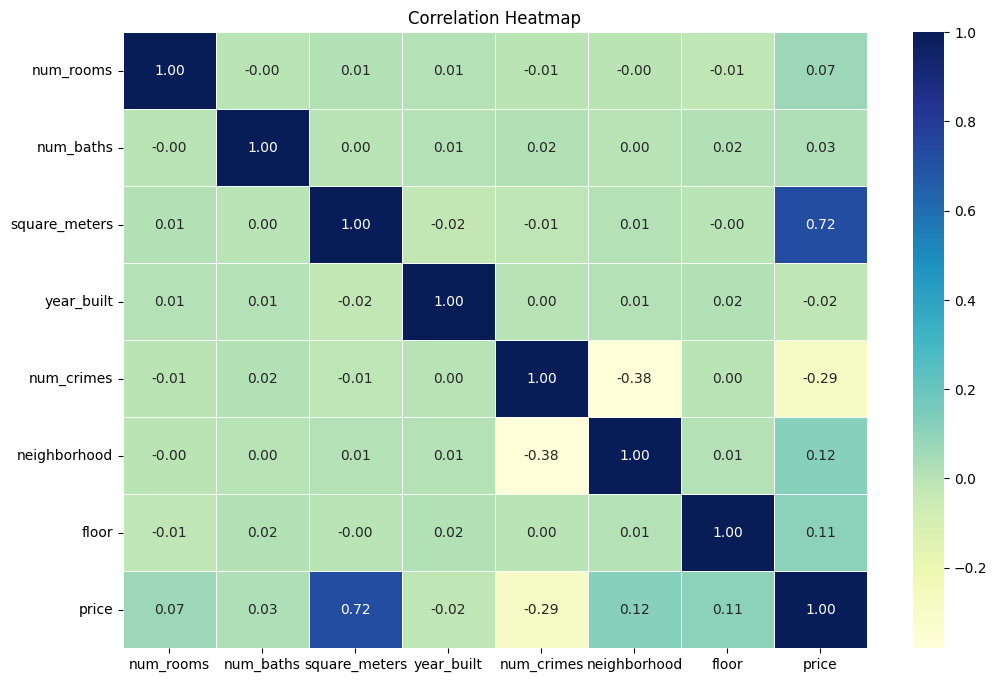

In [134]:
# Create a correlation matrix and heatmap
correlation_matrix = cleaned_data[['num_rooms',	'num_baths','square_meters','year_built','num_crimes','neighborhood','floor','price']].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='YlGnBu', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

We can see both from the pairplots and the correlation matrix that the main features correlated to price are square_meters, num_crimes, neighborhood and floor in that order.

In [135]:
# Use Winsorizer for extreme values
capper = Winsorizer(capping_method = 'gaussian',
                    #Which tail to cap values, here I choose the right tail to cap high values
                    tail = 'both',
                    #Fold indicates the number of standard deviations
                    fold = 3,
                    variables = ['price'])

#Fit the capper to the data
capper.fit(cleaned_data)
#Cap extreme values in the data
cleaned_data = capper.transform(cleaned_data)

Fill the missing data in neighborhood using a model with the rest of the data

In [136]:
# Split the data into two sets: one with missing values and one without for neighborhood
data_missing = cleaned_data[cleaned_data['neighborhood'].isnull()]
data_not_missing = cleaned_data.dropna(subset=['neighborhood','num_rooms', 'square_meters', 'num_baths', 'year_built', 'price'])

# Define features and target variable
X = data_not_missing[['num_rooms', 'square_meters', 'num_baths', 'year_built', 'price']]
y = data_not_missing['neighborhood']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=220)

# Train a RandomForestClassifier to predict "neighborhood"
model = RandomForestClassifier(random_state=220)
model.fit(X_train, y_train)

# Predict the missing values
predicted_neighborhood = model.predict(data_missing[['num_rooms', 'square_meters', 'num_baths', 'year_built', 'price']])

# Fill in the missing values in the original DataFrame
cleaned_data.loc[cleaned_data['neighborhood'].isnull(), 'neighborhood'] = predicted_neighborhood
cleaned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7965 entries, 0 to 7964
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             7965 non-null   int64  
 1   num_rooms      7922 non-null   float64
 2   num_baths      7823 non-null   float64
 3   square_meters  7750 non-null   float64
 4   year_built     7811 non-null   float64
 5   is_furnished   7800 non-null   object 
 6   has_pool       7812 non-null   object 
 7   neighborhood   7965 non-null   float64
 8   num_crimes     7807 non-null   float64
 9   has_ac         7797 non-null   object 
 10  accepts_pets   7810 non-null   object 
 11  price          7965 non-null   float64
 12  floor          7816 non-null   float64
dtypes: float64(8), int64(1), object(4)
memory usage: 809.1+ KB


In [137]:
# Create KNNImputer object with k=6 to fill the rest of the missing data
imputer = KNNImputer(n_neighbors=6)

# Perform KNN imputation
imputed_data = imputer.fit_transform(cleaned_data[['id', 'num_rooms', 'num_baths', 'square_meters',
    'year_built', 'is_furnished', 'has_pool', 'neighborhood', 'num_crimes',
    'has_ac', 'accepts_pets', 'price', 'floor']])

# Convert the imputed data back to DataFrame
imputed_data = pd.DataFrame(imputed_data, columns=cleaned_data[['id', 'num_rooms', 'num_baths', 'square_meters',
    'year_built', 'is_furnished', 'has_pool', 'neighborhood', 'num_crimes',
    'has_ac', 'accepts_pets', 'price', 'floor']].columns)


In [138]:
# Drop Supermarket and Orientation column
cleaned_td = test_data.drop(columns=['num_supermarkets','orientation'])

# Add floor and door_nbr
cleaned_td['floor'] = cleaned_td['door'].str.extract(r'(\d+)º')
cleaned_td['floor'] = pd.to_numeric(cleaned_td['floor'], errors='coerce').convert_dtypes()
cleaned_td.reset_index(inplace=True)
cleaned_td = cleaned_td.drop(columns=['door','index'])

#Map Neighborhood
cleaned_td['neighborhood'] = cleaned_td['neighborhood'].map(neighborhood_mapping)

# Join with previous data
total_data = pd.concat([imputed_data, cleaned_td])
total_data['square_meters'] = np.where(total_data['square_meters']<0, np.NaN, total_data['square_meters'])
total_data['square_meters'] = total_data['square_meters'].fillna(total_data['square_meters'].mean())
total_data['num_rooms'] = np.where(total_data['num_rooms']>6, np.NaN, total_data['num_rooms'])

# Fill missing data in rooms, baths and year by sorting sqr_mts and using ffill
total_data.sort_values('square_meters', inplace=True)
total_data[['num_rooms', 'square_meters', 'num_baths', 'year_built']] = total_data[['num_rooms', 'square_meters', 'num_baths', 'year_built']].ffill()

# Fill missing data in neighborhood and orientation by sorting other values and using ffill
total_data.sort_values(['year_built', 'num_rooms', 'square_meters', 'num_baths'], inplace=True)
total_data[['neighborhood']] = total_data[['neighborhood']].ffill()
total_data.reset_index(inplace=True, drop=True)
total_data.head()

,id,num_rooms,num_baths,square_meters,year_built,is_furnished,has_pool,neighborhood,num_crimes,has_ac,accepts_pets,price,floor
0,9290.00,1.00,1.00,50.00,1950.00,0.00,1.00,2.00,5.00,1.00,0.00,294.00,7.00
1,5366.00,1.00,3.00,57.00,1950.00,1.00,1.00,2.00,0.00,0.00,0.00,920.00,5.00
2,5455.00,1.00,2.00,58.00,1950.00,False,True,2.00,3.00,True,False,NaN,6.00
3,7641.00,1.00,3.00,60.00,1950.00,True,True,2.00,9.00,False,True,NaN,8.00
4,1990.00,1.00,1.00,64.00,1950.00,0.00,0.00,3.00,0.00,0.00,1.00,933.00,4.00


In [139]:
# Create KNNImputer object with k=6 to fill the missing data
imputer = KNNImputer(n_neighbors=7)

# Perform KNN imputation
imputed_td = imputer.fit_transform(total_data[['id', 'num_rooms', 'num_baths', 'square_meters', 'year_built',
    'is_furnished', 'has_pool', 'neighborhood', 'num_crimes', 'has_ac',
    'accepts_pets', 'floor']])

# Convert the imputed data back to DataFrame
imputed_td = pd.DataFrame(imputed_td, columns=total_data[['id', 'num_rooms', 'num_baths', 'square_meters', 'year_built',
    'is_furnished', 'has_pool', 'neighborhood', 'num_crimes', 'has_ac',
    'accepts_pets', 'floor']].columns)

# Approximate values to True or False
imputed_td[['is_furnished', 'has_pool', 'num_crimes', 'has_ac', 'accepts_pets']] = imputed_td[['is_furnished', 'has_pool', 'num_crimes', 'has_ac', 'accepts_pets']].round()
imputed_td = imputed_td.join(total_data[['id', 'price']].set_index('id'), on='id', rsuffix='_total', how='left')


In [140]:
# Standardize values
imputed_td['num_rooms'] = (imputed_td['num_rooms'] - np.mean(imputed_td['num_rooms'])) / np.std(imputed_td['num_rooms'])
imputed_td['num_baths'] = (imputed_td['num_baths'] - np.mean(imputed_td['num_baths'])) / np.std(imputed_td['num_baths'])
imputed_td['square_meters'] = (imputed_td['square_meters'] - np.mean(imputed_td['square_meters'])) / np.std(imputed_td['square_meters'])
imputed_td['neighborhood'] = (imputed_td['neighborhood'] - np.mean(imputed_td['neighborhood'])) / np.std(imputed_td['neighborhood'])
imputed_td['num_crimes'] = (imputed_td['num_crimes'] - np.mean(imputed_td['num_crimes'])) / np.std(imputed_td['num_crimes'])
imputed_td['floor'] = (imputed_td['floor'] - np.mean(imputed_td['floor'])) / np.std(imputed_td['floor'])
imputed_td['year_built'] = (imputed_td['year_built'] - np.mean(imputed_td['year_built'])) / np.std(imputed_td['year_built'])

In [141]:
# Predicting Values
# Separate data from test
cleaned_test = imputed_td[imputed_td['price'].isnull()]
cleaned_data = imputed_td.dropna(subset=['price'])

# Define features and target
# feature_columns=['num_rooms', 'num_baths', 'square_meters', 'year_built',
#     'is_furnished', 'has_pool', 'num_crimes', 'has_ac', 'accepts_pets',
#     'floor', 'neighborhood']
feature_columns=['num_rooms', 'num_baths', 'square_meters', 'num_crimes', 'floor', 'neighborhood']
X = cleaned_data[feature_columns]
y = cleaned_data['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=333)

In [142]:
# Use LazyRegressor for automatic model selection and evaluation
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

# Display the models and their performance metrics
print(models)

# The predictions DataFrame contains the predicted values from various models
print(predictions)

  0%|          | 0/42 [00:00<?, ?it/s]

100%|██████████| 42/42 [00:27<00:00,  1.54it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 206
[LightGBM] [Info] Number of data points in the train set: 6372, number of used features: 6
[LightGBM] [Info] Start training from score 1101.391430
                               Adjusted R-Squared  R-Squared    RMSE  \
Model                                                                  
Lasso                                        0.64       0.64  159.70   
LassoLars                                    0.64       0.64  159.70   
LassoCV                                      0.64       0.64  159.70   
LassoLarsCV                                  0.64       0.64  159.70   
LarsCV                                       0.64       0.64  159.70   
BayesianRidge                                0.64       0.64  159.70   
RidgeCV           

In [143]:
# # Choose the best model (in this case, RidgeCV)
# alphas = [0.1, 1.0, 10.0]
# best_model = HuberRegressor()
# best_model.fit(X, y)

# cleaned_test['price'] = best_model.predict(cleaned_test[feature_columns])

# # Export cleaned_test id and prices rounded and without decimals to a csv
# cleaned_test[['id','price']].astype(int).to_csv('sub3.csv', index=False)